This notebook is used to assess the p-value distributions from the SPIA tests

In [1]:
import sys
import time
import os
import getpass
import json
import itertools as itt
from collections import defaultdict

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest, ks_2samp

In [2]:
%matplotlib inline

In [3]:
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]


In [4]:
print(time.asctime())

Fri May 24 19:30:07 2019


In [5]:
print(getpass.getuser())

cthoyt


In [6]:
databases = ['kegg', 'wikipathways', 'reactome']
datasets = ['brca', 'kirc', 'lihc', 'prad']
prefixes = {
    'kegg': 'hsa', 
    'wikipathways': 'WP',
    'reactome':'R-HSA',
}

# GSEA

In [7]:
gsea_directory = '/Users/cthoyt/Desktop/pf_results/output/gsea/'

In [8]:
gsea_dfs = []

def name_to_database(name):
    for database, prefix in prefixes.items():
        if name.startswith(prefix):
            return database

for dataset in datasets:
    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(gsea_directory, f'{db1}_{db2}_{dataset}.tsv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, sep='\t')
        df['comparison'] = f'{db1}_{db2}'
        df['db'] = df['Term'].map(name_to_database)
        df['dataset'] = dataset
        gsea_dfs.append(df)

gsea_df = pd.concat(gsea_dfs)

In [9]:
gsea_df.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,comparison,db,dataset
0,hsa03030,-0.511916,-1.428605,0.040000,0.286401,36,36,RFC1;RPA1;RPA2;RNASEH2B;RNASEH1;POLE4;POLA1;PO...,RFC5;RPA4;SSBP1;PRIM1;POLE;MCM5;POLD2;MCM7;RFC...,kegg_wikipathways,kegg,brca
1,WP2828,-0.360112,-1.450696,0.145833,0.288069,41,40,EGF;PIK3R1;EGFR;HBEGF;MYC;DAPK2;RPS6KA5;CDKN1A...,TYMP;ERBB2;FGFR3;E2F1;CDKN2A;MMP9;MMP1,kegg_wikipathways,wikipathways,brca
2,hsa03050,-0.431336,-1.361182,0.058824,0.308791,45,45,PSMB11;PSMC1;PSMD6;PSMD7;PSMA8;PSMF1;PSMC6;PSM...,PSMC6;PSMB1;PSMA1;PSMB6;PSMB7;PSME3;PSMD1;PSMD...,kegg_wikipathways,kegg,brca
3,WP4022,-0.325892,-1.343728,0.166667,0.311189,86,84,DPYS;DPYD;TK2;POLR3GL;POLR1E;CMPK1;DHODH;ENPP3...,POLR1B;POLA1;UPP1;UMPS;NME6;POLD3;POLR3C;RRM2B...,kegg_wikipathways,wikipathways,brca
4,WP183,-0.405517,-1.376865,0.185185,0.320513,64,62,HLA-E;NEDD4;UBE2B;UBC;UBE2D3;PSMC1;UBA7;UBE2D1...,UBB;PSMC6;PSMB1;PSMD5;PSMA1;PSMD9;PSMB6;PSMB7;...,kegg_wikipathways,wikipathways,brca


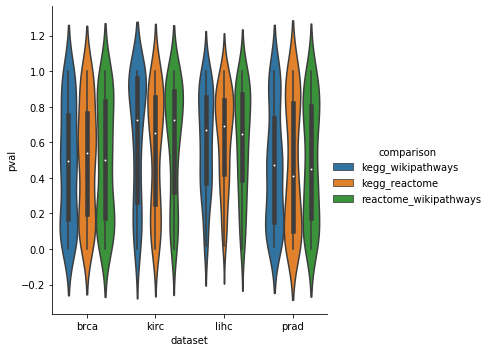

In [10]:
sns.catplot(
    data=gsea_df,
    y='pval',
    x='dataset',
    kind='violin',
    hue='comparison',
)
plt.show()

In [11]:
gsea_ks_rows = []

for dataset in datasets:
    dataset_df = gsea_df[gsea_df.dataset == dataset]    
    for comparison in dataset_df.comparison.unique():
        dataset_comparison_df = dataset_df[dataset_df.comparison == comparison]
        
        # 1 sample KS test
        _, v_1s = kstest(dataset_comparison_df.pval.values, 'uniform')
        
        # 2 sample KS test
        _, v_2s = ks_2samp(*[
            group.pval.values
            for name, group in dataset_comparison_df.groupby('db')
        ])
        gsea_ks_rows.append((dataset, comparison, v_1s, v_2s))

gsea_ks_df = pd.DataFrame(
    gsea_ks_rows, 
    columns=['dataset', 'comparison', 'ks_1s_p_value', 'ks_2s_p_value'],
)
gsea_ks_df

/Users/cthoyt/.virtualenvs/pathme/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/cthoyt/.virtualenvs/pathme/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/cthoyt/.virtualenvs/pathme/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


,dataset,comparison,ks_1s_p_value,ks_2s_p_value
0,brca,kegg_wikipathways,2.414834e-01,0.401543
1,brca,kegg_reactome,5.277138e-01,0.619369
2,brca,reactome_wikipathways,2.412733e-01,0.371364
3,kirc,kegg_wikipathways,2.699498e-07,0.859989
4,kirc,kegg_reactome,1.802267e-03,0.474083
5,kirc,reactome_wikipathways,8.808481e-06,0.879095
6,lihc,kegg_wikipathways,4.526334e-03,0.655476
7,lihc,kegg_reactome,3.891285e-05,0.117687
8,lihc,reactome_wikipathways,2.543294e-03,0.879095
9,prad,kegg_wikipathways,7.957324e-02,0.951316


# SPIA

In [12]:
spia_directory = '/Users/cthoyt/Desktop/pf_results/output/spia/'

In [13]:
spia_dfs = []

def get_spia_database(name):
    name = str(name)
    if name.startswith('WP'):
        return 'wikipathways'
    elif len(name) <= 4:
        return 'kegg'
    else:
        return 'reactome'

for dataset in datasets:
    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(spia_directory, f'{dataset}_{db1}_{db2}_spia.csv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path)
        df['comparison'] = f'{db1}_{db2}'
        df['db'] = df['Name'].map(get_spia_database)
        df['dataset'] = dataset
        spia_dfs.append(df)

spia_df = pd.concat(spia_dfs)

In [14]:
spia_df.head()

,Unnamed: 0,Name,ID,pSize,NDE,pNDE,tA,pPERT,pG,pGFdr,pGFWER,Status,KEGGLINK,comparison,db,dataset
0,1,WP3888,WP3888,158,158,2.739546e-12,2.844327,0.190000,1.524270e-11,3.048540e-10,3.048540e-10,Activated,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,wikipathways,brca
1,2,8982491,8982491,7,7,3.081268e-01,-69.807270,0.000005,2.215943e-05,1.990071e-04,4.431885e-04,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,reactome,brca
2,3,WP179,WP179,67,67,1.266698e-05,-2.348411,0.182000,3.222996e-05,1.990071e-04,6.445992e-04,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,wikipathways,brca
3,4,WP366,WP366,69,69,9.043902e-06,0.535476,0.320000,3.980143e-05,1.990071e-04,7.960286e-04,Activated,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,wikipathways,brca
4,5,WP49,WP49,36,36,2.342279e-03,2.018391,0.050000,1.177272e-03,4.709087e-03,2.354543e-02,Activated,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,wikipathways,brca


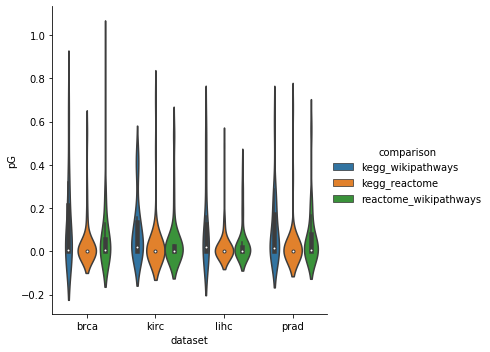

In [15]:
sns.catplot(
    data=spia_df,
    y='pG',
    x='dataset',
    kind='violin',
    hue='comparison',
)
plt.show()

In [16]:
spia_ks_rows = []

for dataset in datasets:
    dataset_df = spia_df[spia_df.dataset == dataset]    
    for comparison in dataset_df.comparison.unique():
        dataset_comparison_df = dataset_df[dataset_df.comparison == comparison]
        
        # 1 Sample
        _, v_1s = kstest(dataset_comparison_df['pG'].values, 'uniform')

        # 2 sample KS test
        _, v_2s = ks_2samp(*[
            group['pG'].values
            for name, group in dataset_comparison_df.groupby('db')
        ])
        spia_ks_rows.append((dataset, comparison, v_1s, v_2s))

spia_ks_df = pd.DataFrame(spia_ks_rows, columns=['dataset', 'comparison', 'ks_1s_p_value', 'ks_2s_p_value'])
spia_ks_df

,dataset,comparison,ks_1s_p_value,ks_2s_p_value
0,brca,kegg_wikipathways,1.502832e-07,0.145929
1,brca,kegg_reactome,5.983778e-28,0.006610
2,brca,reactome_wikipathways,3.017047e-22,0.000002
3,kirc,kegg_wikipathways,4.353518e-10,0.193513
4,kirc,kegg_reactome,9.645930e-34,0.006610
5,kirc,reactome_wikipathways,2.860489e-28,0.000012
6,lihc,kegg_wikipathways,2.249701e-08,0.323428
7,lihc,kegg_reactome,7.779038e-31,0.006610
8,lihc,reactome_wikipathways,2.416174e-27,0.000012
9,prad,kegg_wikipathways,1.509707e-09,0.193513


# ORA

In [17]:
ora_directory = '/Users/cthoyt/Desktop/pf_results/output/ora_geometric/'

In [19]:
ora_dfs = []

for dataset in datasets:
    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(ora_directory, f'ora_geometric_{db1}_{db2}_{dataset}.tsv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, sep='\t')
        df['comparison'] = f'{db1}_{db2}'
        df['db'] = df['pathway_id'].map(name_to_database)
        df['dataset'] = dataset
        ora_dfs.append(df)

ora_df = pd.concat(ora_dfs)
ora_df.head()

,pathway_id,pval,qval,comparison,db,dataset
0,hsa00020,0.010393,0.022586,kegg_reactome,kegg,brca
1,hsa00310,0.001123,0.003732,kegg_reactome,kegg,brca
2,hsa00562,0.001431,0.004399,kegg_reactome,kegg,brca
3,R-HSA-428157,0.020046,0.038689,kegg_reactome,reactome,brca
4,hsa00620,0.000693,0.002527,kegg_reactome,kegg,brca


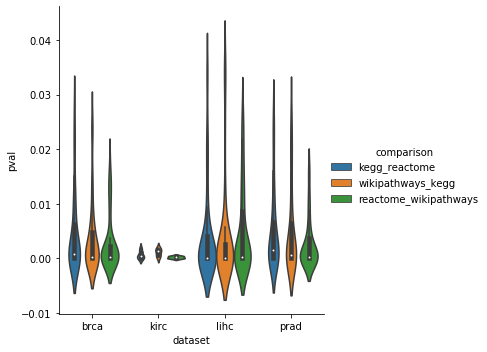

In [20]:
sns.catplot(
    data=ora_df,
    y='pval',
    x='dataset',
    kind='violin',
    hue='comparison',
)
plt.show()

In [21]:
ora_ks_rows = []

for dataset in datasets:
    dataset_df = ora_df[ora_df.dataset == dataset]    
    for comparison in dataset_df.comparison.unique():
        dataset_comparison_df = dataset_df[dataset_df.comparison == comparison]
        
        # 1 Sample
        _, v_1s = kstest(dataset_comparison_df['pval'].values, 'uniform')

        # 2 sample KS test
        _, v_2s = ks_2samp(*[
            group['pval'].values
            for name, group in dataset_comparison_df.groupby('db')
        ])
        ora_ks_rows.append((dataset, comparison, v_1s, v_2s))

ora_ks_df = pd.DataFrame(
    ora_ks_rows, 
    columns=['dataset', 'comparison', 'ks_1s_p_value', 'ks_2s_p_value'],
)
ora_ks_df

,dataset,comparison,ks_1s_p_value,ks_2s_p_value
0,brca,kegg_reactome,4.491420e-99,0.432213
1,brca,wikipathways_kegg,1.258799e-107,0.981955
2,brca,reactome_wikipathways,8.648645e-85,0.305373
3,kirc,kegg_reactome,2.910889e-22,0.014489
4,kirc,wikipathways_kegg,4.496786e-14,0.150366
5,kirc,reactome_wikipathways,1.485559e-23,0.886795
6,lihc,kegg_reactome,1.973825e-123,0.379118
7,lihc,wikipathways_kegg,1.461325e-124,0.218447
8,lihc,reactome_wikipathways,1.571363e-107,0.080109
9,prad,kegg_reactome,1.426819e-107,0.736750
